# CPSC 585 Project 3
Group 5

## Group Members
* Andrew Abel
* Shayan Darian
* Harshita Mhaske
* Bharti Moryani
* Jeffrey Rhoten

## Contributions

Andrew Abel:

20%

Shayan Darian:

20%

Harshita Mhaske:

20%

Bharti Moryani:

20%

Jeffrey Rhoten:

20%

## Project Details

Our project covers word embeddings, construction of RNN's for regression and classifcation, and a Transformer.

The final version of our code is located under the "Large & Smaller (Combined) Dataset" heading. We have included other versions of the code below in the "Large Dataset (only)" section to document our progress and improvements over time.

# Large & Smaller (Combined) Dataset

In this section, we trained and tested our models on larger dataset by combining .csv and .json data.

## Connect with drive and import libraries

Import collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 14.6 MB/s eta 0:00:00


Import libraries

In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers import LayerNormalization, Dropout, Input
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import contractions
import re
import numpy as np

## Preprocessing

Import csv dataset located in google drive

In [ ]:
# Import csv dataset located in google drive
csv_dataset_path = '/content/drive/MyDrive/Colab Notebooks/RateMyProfessor_Sample data.csv'
df_csv = pd.read_csv(csv_dataset_path)

Import json dataset also located in google drive

In [ ]:
# Import json dataset also located in google drive
json_dataset_path = '/content/drive/MyDrive/Colab Notebooks/all_reviews.json'
df_json = pd.read_json(json_dataset_path)

Open and Read json.

In [ ]:
# Load the JSON file
with open(json_dataset_path, 'r') as f:
    data = json.load(f)

# Display the first few rows to inspect the structure
print(data[:2])  # Print the first two rows for inspection

[[{'course_id': ' FHS010', 'Quality': '5.0', 'Difficulty': '2.0', 'For Credit': 'Yes', 'Would Take Again': 'Yes', 'Grade': 'A', 'Textbook': 'No', 'Comment': "Professor Nichols is super nice and very wholesome! There is a lot of reading, but you can get by without doing very much of it. He does talk a LOT and doesn't foster as much discussion, but I think the latter might also be because people stop doing the readings a few weeks in. He does appreciate participation and gives great essay feedback!", 'professor': 'James Nichols ', 'department': 'Government department'}, {'course_id': ' FHS010', 'Quality': '3.0', 'Difficulty': '1.0', 'For Credit': 'Yes', 'Attendance': 'Mandatory', 'Would Take Again': 'No', 'Textbook': 'No', 'Comment': 'Very chill class and teacher, very easy grader, but talks for most of the class and does not really foster discussion.', 'professor': 'James Nichols ', 'department': 'Government department'}, {'course_id': ' POLPHILOSOPHY', 'Quality': '4.0', 'Difficulty': '

Create 3 different vectors to store comments, quality and difficulty fields from json and use pandas to create dataframe using all 3 vectors with different headers.

In [ ]:
# Initialize lists to store extracted values
comments = []
quality = []
difficulty = []

# Extract values from each entry in data
for sublist in data:
    for entry in sublist:
        comments.append(entry.get('Comment', ''))
        quality.append(entry.get('Quality', ''))
        difficulty.append(entry.get('Difficulty', ''))

# Create a DataFrame from the extracted lists
df_json_selected = pd.DataFrame({
    'comments': comments,
    'quality': quality,
    'difficulty': difficulty
})

# Display the first few rows to verify the data
print(df_json_selected.head())

                                            comments quality difficulty
0  Professor Nichols is super nice and very whole...     5.0        2.0
1  Very chill class and teacher, very easy grader...     3.0        1.0
2  Awesome, easy, knows literally everything abou...     4.0        1.0
3  Prof. Nichols is a super nice and encouraging ...     5.0        2.0
4  Good Professor. Really nice and encouraging te...     5.0        1.0


In [ ]:
# Test print of data to view columns in JSON data
print("Columns in JSON dataframe:")
print(df_json_selected.columns)

Columns in JSON dataframe:
Index(['comments', 'quality', 'difficulty'], dtype='object')


Select columns of interest from the JSON dataframe

In [ ]:
# Select columns of interest from the JSON dataframe
df_json_selected = df_json_selected[['comments', 'quality', 'difficulty']]

Select columns of interest from the RateMyProfessor CSV dataframe

In [ ]:
# Select columns of interest from the RateMyProfessor CSV dataframe
df_csv_selected = df_csv[['comments', 'student_star', 'student_difficult']]

Combine the data into a single dataframe i.e combined_df

In [ ]:
# Combine the data into a single dataframe
combined_df = pd.DataFrame()

# Concatenate 'comments' columns from both datasets
combined_df['comments'] = pd.concat([df_json_selected['comments'], df_csv_selected['comments']], ignore_index=True)

# Combine 'quality' and 'student_star' into 'quality' column
combined_df['quality'] = pd.concat([df_json_selected['quality'], df_csv_selected['student_star']], ignore_index=True)

# Combine 'difficulty' and 'student_difficult' into 'difficulty' column
combined_df['difficulty'] = pd.concat([df_json_selected['difficulty'], df_csv_selected['student_difficult']], ignore_index=True)

# Display the combined dataframe
print(combined_df)


                                                comments quality difficulty
0      Professor Nichols is super nice and very whole...     5.0        2.0
1      Very chill class and teacher, very easy grader...     3.0        1.0
2      Awesome, easy, knows literally everything abou...     4.0        1.0
3      Prof. Nichols is a super nice and encouraging ...     5.0        2.0
4      Good Professor. Really nice and encouraging te...     5.0        1.0
...                                                  ...     ...        ...
23369   Great sense of humor!!!! Love parasites now!!!!!     1.5        5.0
23370  he is a really nice guy and is really funny..h...     2.5        4.0
23371  His parasitology class is a lot of work but he...     5.0        3.0
23372  He is WAY too much work for a 1 credit class. ...     4.0        5.0
23373  Extremely easy lab teacher, quizzes are a litt...     5.0        2.0

[23374 rows x 3 columns]


This part is optional. It's just creating output file to hold combined data from csv and json datasets.

In [ ]:
# Create output file to hold combined data from csv and json datasets
output_file = '/content/drive/MyDrive/Colab Notebooks/combinedJsonCSV.csv'

# Save to CSV
combined_df.to_csv(output_file, index=False)

Original data points in csv are 20000 whereas after combining it with json, resultant data points are 23374.

In [ ]:
# Count number of rows in original RateMyProfessor CSV file
original_rows = df_csv.shape[0]

# Count number of rows in combined dataframe
combined_rows = combined_df.shape[0]

# Print row counts to compare amount of data added
print(f"Number of rows in original RateMyProfessor CSV file: {original_rows}")
print(f"Number of rows in combined dataframe: {combined_rows}")

Number of rows in original RateMyProfessor CSV file: 20000
Number of rows in combined dataframe: 23374


In [ ]:
# Check headers
print("Headers of the combined dataframe:")
print(combined_df.columns)

Headers of the combined dataframe:
Index(['comments', 'quality', 'difficulty'], dtype='object')


This removes missing values from dataframe combined_df and store resulting data in new dataframe df.

In [ ]:
# Remove missing values
df = combined_df.dropna(subset=['comments', 'quality', 'difficulty'])

Data preprocessing by applying contractions and removing punctuations from the text.

In [ ]:
import pandas as pd
import contractions
import re

# Assuming you've already imported your data and created the DataFrame 'df'

# Drop rows with NaN values in specified columns
df = df.dropna(subset=['comments', 'quality', 'difficulty'])

# Create a new column to store the comments before applying contractions
df['comments_before'] = df['comments']

# Expand contractions in the 'comments' column
df['comments'] = df['comments'].apply(contractions.fix)

# Lowercasing
df['comments'] = df['comments'].str.lower()

# Removing Punctuation and Special Characters
df['comments'] = df['comments'].apply(lambda x: re.sub(r'[^\w\s-]', '', x))
df['comments'] = df['comments'].apply(lambda x: x.replace('/', ' '))

df['comments'] = df['comments'].apply(lambda x: re.sub(r'(\w+)\s?/\s?(\w+)', r'\1 \2', x))



# Extract columns
comments_before = df['comments_before'].values
comments_after = df['comments'].values

# Test print to show before & after preprocessing
for i in range(10):
    print("Before:", comments_before[i])
    print("After:", comments_after[i])
    print("-------------------------")

Before: Professor Nichols is super nice and very wholesome! There is a lot of reading, but you can get by without doing very much of it. He does talk a LOT and doesn't foster as much discussion, but I think the latter might also be because people stop doing the readings a few weeks in. He does appreciate participation and gives great essay feedback!
After: professor nichols is super nice and very wholesome there is a lot of reading but you can get by without doing very much of it he does talk a lot and does not foster as much discussion but i think the latter might also be because people stop doing the readings a few weeks in he does appreciate participation and gives great essay feedback
-------------------------
Before: Very chill class and teacher, very easy grader, but talks for most of the class and does not really foster discussion.
After: very chill class and teacher very easy grader but talks for most of the class and does not really foster discussion
-------------------------


Here we are creating 3 different variables to hold comments, quality and difficulty data from text, so that we don't have to write df[variable_name] everytime we need to use this.

In [ ]:
# Create variables to hold values
comments = df['comments'].values
quality_labels = df['quality'].values
difficulty_labels = df['difficulty'].values

This part is to check what all unique labels are there in quality and difficulty label columns.

In [ ]:
import numpy as np
quality_labels = quality_labels.astype(float)
difficulty_labels = difficulty_labels.astype(float)

# Get unique quality labels
unique_quality_labels = np.unique(quality_labels[~np.isnan(quality_labels)])

# Get unique difficulty labels
unique_difficulty_labels = np.unique(difficulty_labels[~np.isnan(difficulty_labels)])

# Count number of unique quality labels
num_unique_quality_labels = len(unique_quality_labels)

# Count number of unique difficulty labels
num_unique_difficulty_labels = len(unique_difficulty_labels)

# Print label counts for quality and difficulty
print("Number of unique quality labels:", num_unique_quality_labels)
print("Unique quality labels:", unique_quality_labels)

print("Number of unique difficulty labels:", num_unique_difficulty_labels)
print("Unique difficulty labels:", unique_difficulty_labels)

Number of unique quality labels: 9
Unique quality labels: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Number of unique difficulty labels: 5
Unique difficulty labels: [1. 2. 3. 4. 5.]


These thresholds divide the continuous range of label values into intervals. Each interval corresponds to a specific class.
For example, the quality thresholds [0, 2.5, 3.5, 5] define the following intervals:
[0, 2.5)
[2.5, 3.5)
[3.5, 5)
Similarly, the difficulty thresholds [0, 2, 3, 5] define these intervals:
[0, 2)
[2, 3)
[3, 5)

The np.digitize function assigns each label to a class based on which interval (defined by the thresholds) the label falls into.
np.digitize returns the index of the bin each label belongs to. Subtracting 1 adjusts the class indices to start from 0.
For example, if a quality label is 3, np.digitize with the given quality_thresholds would return 2 (since 3 falls into the second interval [2.5, 3.5)). Subtracting 1 gives the class label 1.

We are doing this so that model can learn faster and better. We can remmeber small things faster, so do the model.

In [ ]:
# Define classification thresholds for quality labels
quality_thresholds = [0, 2.5, 3.5, 5]

# Define classification thresholds for difficulty labels
difficulty_thresholds = [0, 2, 3, 5]

# Convert labels to classes
quality_classes = np.digitize(quality_labels, bins=quality_thresholds) - 1
difficulty_classes = np.digitize(difficulty_labels, bins=difficulty_thresholds) - 1

This is just to confirm the resultant labels for quality and difficulty label columns.

In [ ]:
# Get unique quality labels
unique_quality_labels = np.unique(quality_classes[~np.isnan(quality_classes)])

# Get unique difficulty labels
unique_difficulty_labels = np.unique(difficulty_classes[~np.isnan(difficulty_classes)])

# Test print
print(unique_quality_labels)

print(unique_difficulty_labels)

[0 1 2 3]
[0 1 2 3]


Tokenization

Here we are creating tokens from the text.

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['comments'].values)
sequences = tokenizer.texts_to_sequences(df['comments'].values)
maxlen = 100  # Assuming a maximum sequence length of 100
data = pad_sequences(sequences, maxlen=maxlen)

Split the dataset with a test size of 20% and train size of 80%

In [ ]:
# Train-Test split
x_train, x_test, y_train_quality, y_test_quality, y_train_difficulty, y_test_difficulty = train_test_split(
    data, quality_classes, difficulty_classes, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape)
print(y_train_quality.shape)
print(x_test.shape)
print(y_test_quality.shape)

(18693, 100)
(18693,)
(4674, 100)
(4674,)


Create embedding matrix

In [ ]:
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt', encoding='utf-8') as f:
    next(f)  # Skip the header line
    for line in f:
        values = line.split()
        word = values[0]
        if len(values) > 1:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## RNN

### Regression

Define the RNN model architecture for quality prediction, includes compiling, training and evaulation based of 10 epochs with a batch size of 32.

#### Quality Prediction

Here we have used validation mean square error as early stopping mechanism to stop training early if the validation mean square error does not improve for a certain number of epochs.

An Embedding layer is added with pre-trained weights from embedding_matrix to convert input sequences into dense vectors.
The embedding layer uses len(word_index) + 1 as the input dimension and embedding_dim as the output dimension.

input_length=maxlen defines the maximum length of input sequences.

trainable=False ensures that the pre-trained embeddings are not updated during training.

A Bidirectional LSTM layer with 64 units is added to capture temporal dependencies in the data from both directions.

A Dense layer with a single neuron and linear activation is added for regression output.


##### Interpretation of the Result from Epochs

Quality Prediction MAE: The value 0.5824604034423828 indicates that, on average, the model's predictions for quality labels deviate from the actual values by approximately 0.58 units (on the scale of the quality labels).

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a callback to save the best model during training
checkpoint_path = "quality_model_aug_reg_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_mae', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Create model
quality_model = Sequential()
quality_model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
quality_model.add(Bidirectional(LSTM(64)))
quality_model.add(Dense(1, activation='linear'))

# Compile the quality model
quality_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the quality model
history = quality_model.fit(x_train, y_train_quality, epochs=50, batch_size=32, validation_data=(x_test, y_test_quality), callbacks=[checkpoint, early_stopping])

# Evaluate the quality model
quality_loss, quality_mae = quality_model.evaluate(x_test, y_test_quality)
print("quality prediction:", quality_mae)

Epoch 1/50
585/585 [==============================] - ETA: 0s - loss: 0.9108 - mae: 0.7774
Epoch 1: val_mae improved from inf to 0.63740, saving model to quality_model_aug_reg_checkpoint.h5
585/585 [==============================] - 17s 18ms/step - loss: 0.9108 - mae: 0.7774 - val_loss: 0.6834 - val_mae: 0.6374
Epoch 2/50
  1/585 [..............................] - ETA: 9s - loss: 0.6417 - mae: 0.6333

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


582/585 [============================>.] - ETA: 0s - loss: 0.6427 - mae: 0.6346
Epoch 2: val_mae did not improve from 0.63740
585/585 [==============================] - 9s 15ms/step - loss: 0.6429 - mae: 0.6346 - val_loss: 0.6717 - val_mae: 0.6416
Epoch 3/50
581/585 [============================>.] - ETA: 0s - loss: 0.5811 - mae: 0.6012
Epoch 3: val_mae improved from 0.63740 to 0.60053, saving model to quality_model_aug_reg_checkpoint.h5
585/585 [==============================] - 8s 13ms/step - loss: 0.5812 - mae: 0.6011 - val_loss: 0.5957 - val_mae: 0.6005
Epoch 4/50
585/585 [==============================] - ETA: 0s - loss: 0.5376 - mae: 0.5738
Epoch 4: val_mae did not improve from 0.60053
585/585 [==============================] - 9s 15ms/step - loss: 0.5376 - mae: 0.5738 - val_loss: 0.5822 - val_mae: 0.6029
Epoch 5/50
582/585 [============================>.] - ETA: 0s - loss: 0.5047 - mae: 0.5541
Epoch 5: val_mae did not improve from 0.60053
585/585 [==============================]

##### Graph Results

Plot training results

In [ ]:
# Verify keys available for history to display
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


Visualizing the training and validation loss of the model over the training epochs.

The training and validation loss plot reveals important insights into the model's performance over the epochs:

Training Loss: The training loss consistently decreases with each epoch, indicating that the model is learning from the training data and improving its fit.

Validation Loss: The validation loss initially decreases, suggesting that the model is generalizing well to unseen data. However, after a certain point, the validation loss starts to increase, which is a clear sign of overfitting. This means that the model is starting to memorize the training data rather than learning to generalize from it.

Despite the overfitting observed, the training process was effectively managed by the early stopping mechanism. Early stopping halted the training after the validation loss did not improve for 5 consecutive epochs, preventing further overfitting and saving the best model observed during the training process.

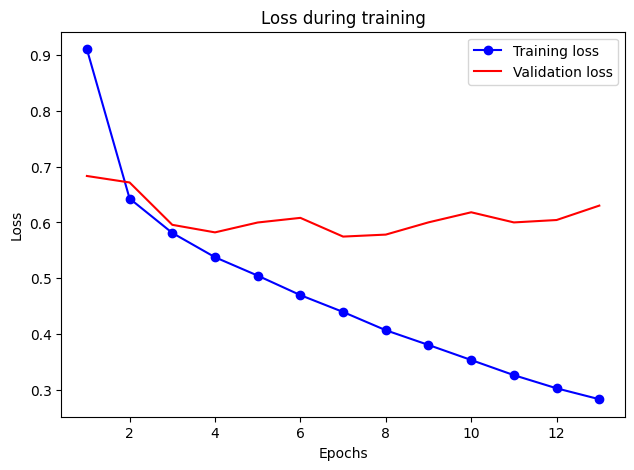

In [ ]:
# Plot loss
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

This code is plotting the Mean Absolute Error (MAE) for both the training and validation sets over the epochs of the training process.

The plot of Mean Absolute Error (MAE) during training provides insights into the model's performance over the epochs:

**Training MAE**: The training MAE consistently decreases with each epoch, indicating that the model is effectively learning and reducing errors on the training data.

**Validation MAE**: The validation MAE shows a more complex behavior. Initially, it decreases, suggesting that the model is improving its generalization to the validation data. However, after a few epochs, the validation MAE starts to fluctuate, increasing for some epochs and then decreasing again. This fluctuation continues for several epochs. Eventually, the validation MAE stabilizes and becomes close to constant, indicating that the model's performance on the validation data is no longer significantly improving or deteriorating.

This pattern suggests that while the model is learning, it experiences periods of instability in its performance on the validation set, likely due to the inherent variability in the validation data. However, the overall trend towards stabilization is a positive sign, indicating that the model has reached a point where its performance is relatively steady.

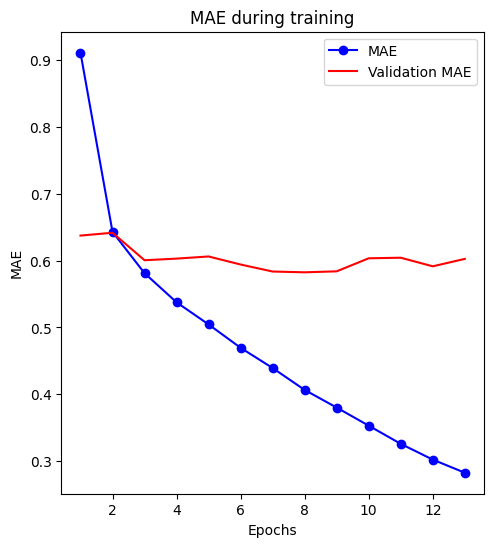

In [ ]:
# Plot MAE
mae = history_dict['mae']
val_mae = history_dict['val_mae']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='MAE')
plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

#### Difficulty Prediction

##### Interpretation of the Result from Epochs

Difficult Prediction MAE: The value 0.6287729740142822 indicates that, on average, the model's predictions for difficulty labels deviate from the actual values by approximately 0.63 units (on the scale of the difficulty labels).

Run the same as above but now for difficulty predictions

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a callback to save the best model during training
checkpoint_path = "difficulty_model_aug_reg_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_mae', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Build the difficulty model
difficulty_model = Sequential()
difficulty_model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
difficulty_model.add(Bidirectional(LSTM(64)))
difficulty_model.add(Dense(1, activation='linear'))  # Output 4 classes for sentiment classification

# Compile the difficulty model
difficulty_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the difficulty model with checkpoint and early stopping callbacks
history = difficulty_model.fit(x_train, y_train_difficulty, epochs=50, batch_size=32, validation_data=(x_test, y_test_difficulty), callbacks=[checkpoint, early_stopping])

# Evaluate the difficulty model
difficulty_loss, difficulty_prediction = difficulty_model.evaluate(x_test, y_test_difficulty)
print("difficulty prediction:", difficulty_prediction)

Epoch 1/50
581/585 [============================>.] - ETA: 0s - loss: 0.8265 - mae: 0.7381
Epoch 1: val_mae improved from inf to 0.70265, saving model to difficulty_model_aug_reg_checkpoint.h5
585/585 [==============================] - 13s 15ms/step - loss: 0.8254 - mae: 0.7376 - val_loss: 0.7107 - val_mae: 0.7027
Epoch 2/50
583/585 [============================>.] - ETA: 0s - loss: 0.6855 - mae: 0.6664
Epoch 2: val_mae improved from 0.70265 to 0.65321, saving model to difficulty_model_aug_reg_checkpoint.h5
585/585 [==============================] - 8s 13ms/step - loss: 0.6853 - mae: 0.6662 - val_loss: 0.6535 - val_mae: 0.6532
Epoch 3/50
583/585 [============================>.] - ETA: 0s - loss: 0.6438 - mae: 0.6435
Epoch 3: val_mae improved from 0.65321 to 0.63485, saving model to difficulty_model_aug_reg_checkpoint.h5
585/585 [==============================] - 10s 17ms/step - loss: 0.6442 - mae: 0.6437 - val_loss: 0.6448 - val_mae: 0.6349
Epoch 4/50
584/585 [=========================

##### Graph Results

Plot Training Results

In [ ]:
# Verify keys available for history to display
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


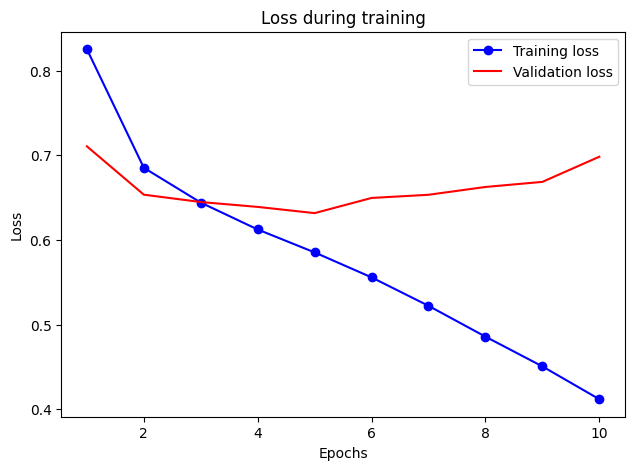

In [ ]:
# Plot loss
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

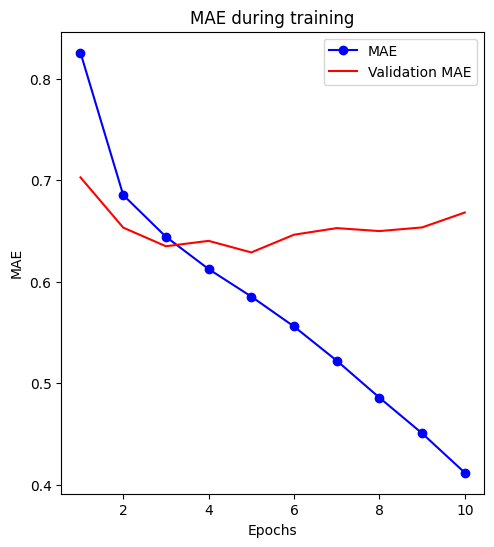

In [ ]:
# Plot MAE
mae = history_dict['mae']
val_mae = history_dict['val_mae']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='MAE')
plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

### Classification

RNN TEXT Classification Model

Neural networks often require the output labels to be in a one-hot encoded format for classification tasks.

Therefore, in this code snippet, the labels for quality and difficulty are being converted into one-hot encoded format using the to_categorical function from Keras.

In [ ]:
from keras.utils import to_categorical

# Convert labels to one-hot encoding
quality_labels_onehot = to_categorical(quality_classes, num_classes=4)
difficulty_labels_onehot = to_categorical(difficulty_classes, num_classes=4)

In [ ]:
x_train, x_test, y_train_quality, y_test_quality, y_train_difficulty, y_test_difficulty = train_test_split(
    data, quality_labels_onehot, difficulty_labels_onehot, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['comments'].values)
sequences = tokenizer.texts_to_sequences(df['comments'].values)
maxlen = 100  # Assuming a maximum sequence length of 100
data = pad_sequences(sequences, maxlen=maxlen)

In [ ]:
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt', encoding='utf-8') as f:
    next(f)  # Skip the header line
    for line in f:
        values = line.split()
        word = values[0]
        if len(values) > 1:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
# Test print data
print(x_train.shape)
print(y_train_quality.shape)
print(x_test.shape)
print(y_test_quality.shape)

(18693, 100)
(18693, 4)
(4674, 100)
(4674, 4)


#### Quality accuracy

This code trains a bidirectional LSTM model for multi-class classification with callbacks to save the best model and stop early if no improvement in validation accuracy. The model uses pre-trained word embeddings and outputs class probabilities for quality classification.

In the provided code, categorical cross-entropy is used as the loss function because the task is a multi-class classification problem.

The softmax activation function in the output layer converts the raw output scores (logits) into a probability distribution. The sum of the probabilities for all classes is 1.

Categorical cross-entropy measures the dissimilarity between the true label distribution (which is one-hot encoded) and the predicted probability distribution. It calculates the negative log probability of the correct class, penalizing the model more when it assigns a lower probability to the correct class.

##### Interpretation of the Result from Epochs

Quality Prediction Accuracy: The value 0.5975610017776489 indicates that the model's accuracy on the test set for predicting the quality labels is approximately 59.82%

An accuracy of 0.5982 means that the model correctly predicts the quality label about 59.82% of the time.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a callback to save the best model during training
checkpoint_path = "quality_model_aug_class_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Build the quality model
quality_model = Sequential()
quality_model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
quality_model.add(Bidirectional(LSTM(64)))
quality_model.add(Dense(4, activation='softmax'))  # Output 4 classes for sentiment classification

# Compile the quality model
quality_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the quality model with checkpoint and early stopping callbacks
history = quality_model.fit(x_train, y_train_quality, epochs=50, batch_size=32, validation_data=(x_test, y_test_quality), callbacks=[checkpoint, early_stopping])

# Evaluate the quality model
quality_loss, quality_accuracy = quality_model.evaluate(x_test, y_test_quality)
print("quality prediction:", quality_accuracy)

Epoch 1/50
582/585 [============================>.] - ETA: 0s - loss: 1.0703 - accuracy: 0.5184
Epoch 1: val_accuracy improved from -inf to 0.56718, saving model to quality_model_aug_class_checkpoint.h5
585/585 [==============================] - 15s 18ms/step - loss: 1.0696 - accuracy: 0.5186 - val_loss: 0.9700 - val_accuracy: 0.5672
Epoch 2/50
582/585 [============================>.] - ETA: 0s - loss: 0.9410 - accuracy: 0.5764
Epoch 2: val_accuracy improved from 0.56718 to 0.58194, saving model to quality_model_aug_class_checkpoint.h5
585/585 [==============================] - 8s 14ms/step - loss: 0.9412 - accuracy: 0.5762 - val_loss: 0.9425 - val_accuracy: 0.5819
Epoch 3/50
585/585 [==============================] - ETA: 0s - loss: 0.8918 - accuracy: 0.5996
Epoch 3: val_accuracy did not improve from 0.58194
585/585 [==============================] - 7s 12ms/step - loss: 0.8918 - accuracy: 0.5996 - val_loss: 0.9435 - val_accuracy: 0.5804
Epoch 4/50
583/585 [===========================

##### Graph Results

Plot Training Results

In [ ]:
# Verify keys available for history to display
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


This code plots the training and validation loss over epochs using Matplotlib.

The plot of loss during training shows the following trends:

**Training Loss:** The training loss consistently decreases with each epoch, indicating that the model is learning and improving its performance on the training data.

**Validation Loss:** The validation loss initially decreases for a few epochs, indicating that the model is also performing well on the validation data. However, after this initial decrease, the validation loss starts to increase, suggesting that the model's performance on unseen validation data begins to deteriorate.

This pattern typically indicates that the model may be overfitting to the training data.

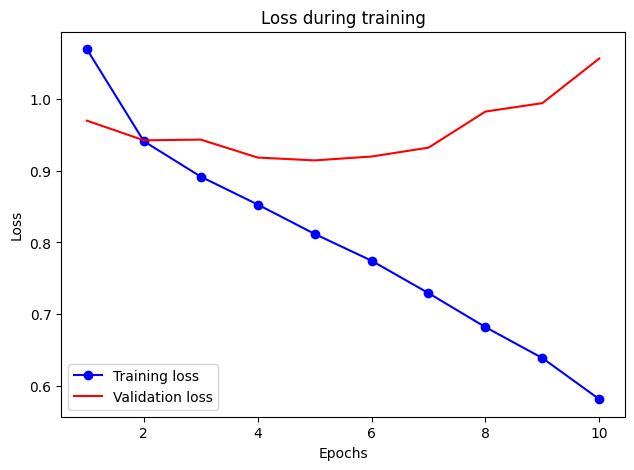

In [ ]:
# Plot loss
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

This code plots the training and validation accuracy over epochs using Matplotlib.

The plot of accuracy during training shows the following trends:

**Training Accuracy:** The training accuracy consistently increases with each epoch, indicating that the model is learning and improving its performance on the training data.

**Validation Accuracy:** The validation accuracy initially increases for a few epochs, indicating that the model is performing well on the validation data. However, after this initial increase, the validation accuracy starts to fluctuate. Eventually, it starts to decrease, suggesting that the model's ability to generalize to new, unseen data is diminishing.

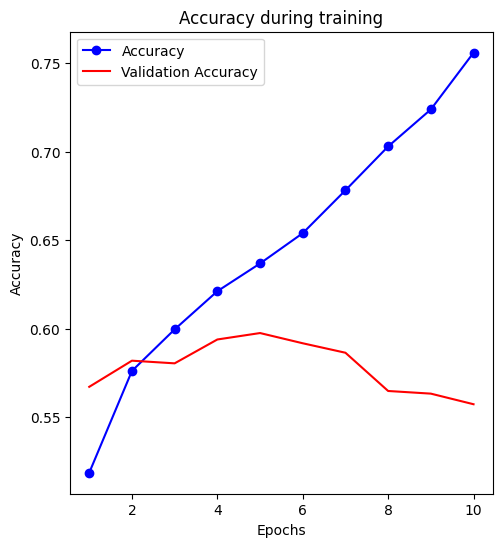

In [ ]:
# Plot Accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Difficulty Prediction

##### Interpretation of the Result from Epochs

Difficulty Accuracy: The value 0.5423619747161865 indicates that the model's accuracy on the test set for predicting correct difficulty labels is approximately 54.23%

An accuracy of 0.5423 means that the model correctly predicts the difficulty label about 54.23% of the time.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a callback to save the best model during training
checkpoint_path = "difficulty_model_aug_class_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Build the difficulty model
difficulty_model = Sequential()
difficulty_model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
difficulty_model.add(Bidirectional(LSTM(64)))
difficulty_model.add(Dense(4, activation='softmax'))  # Output 4 classes for sentiment classification

# Compile the difficulty model
difficulty_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the difficulty model with checkpoint and early stopping callbacks
history = difficulty_model.fit(x_train, y_train_difficulty, epochs=50, batch_size=32, validation_data=(x_test, y_test_difficulty), callbacks=[checkpoint, early_stopping])

# Evaluate the difficulty model
difficulty_loss, difficulty_accuracy = difficulty_model.evaluate(x_test, y_test_difficulty)
print("difficulty prediction:", difficulty_accuracy)

Epoch 1/50
582/585 [============================>.] - ETA: 0s - loss: 1.1883 - accuracy: 0.5048
Epoch 1: val_accuracy improved from -inf to 0.52418, saving model to difficulty_model_aug_class_checkpoint.h5
585/585 [==============================] - 14s 17ms/step - loss: 1.1877 - accuracy: 0.5053 - val_loss: 1.1147 - val_accuracy: 0.5242
Epoch 2/50
583/585 [============================>.] - ETA: 0s - loss: 1.0971 - accuracy: 0.5322
Epoch 2: val_accuracy improved from 0.52418 to 0.53851, saving model to difficulty_model_aug_class_checkpoint.h5
585/585 [==============================] - 8s 13ms/step - loss: 1.0972 - accuracy: 0.5323 - val_loss: 1.0862 - val_accuracy: 0.5385
Epoch 3/50
585/585 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.5527
Epoch 3: val_accuracy improved from 0.53851 to 0.54236, saving model to difficulty_model_aug_class_checkpoint.h5
585/585 [==============================] - 8s 14ms/step - loss: 1.0536 - accuracy: 0.5527 - val_loss: 1.0768 - 

##### Graph Results

Plot Training Results

In [ ]:
# Verify keys available for history to display
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


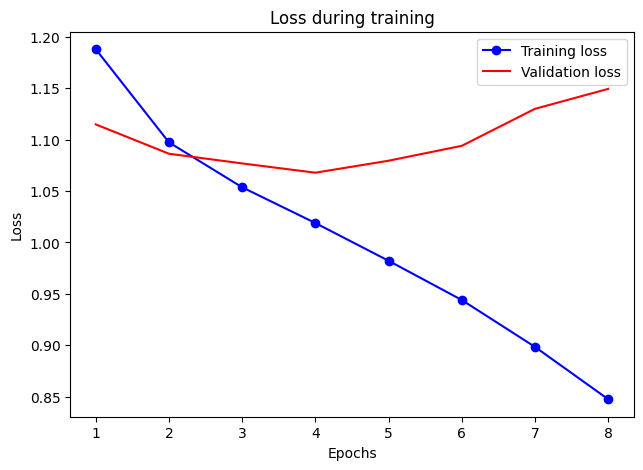

In [ ]:
# Plot loss
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

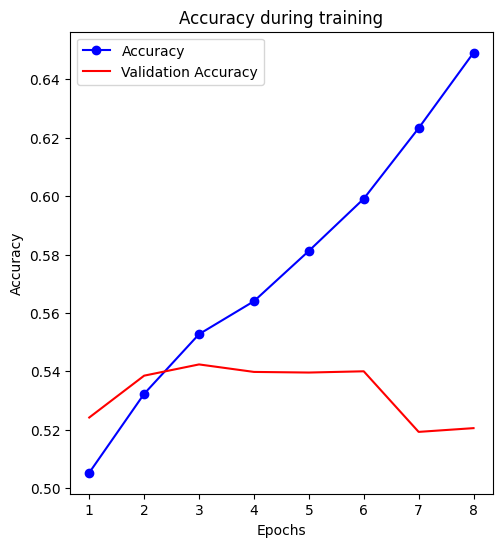

In [ ]:
# Plot Accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Transformer

Import libraries

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout, Input
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
import tensorflow as tf

In [ ]:
x_train, x_test, y_train_quality, y_test_quality, y_train_difficulty, y_test_difficulty = train_test_split(
    data, quality_classes, difficulty_classes, test_size=0.2, random_state=42)

Create Transformer Block

In [ ]:
# Helper functions
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_block(x, num_heads, d_model, rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn_output = Dense(d_model, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

Already have loaded dataset, tokenized, and split dataset from before.
Load GloVe embedding

In [ ]:
# Load GloVe embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Transformer Model Architecture

In [ ]:
# Transformer Model Architecture
input_layer = Input(shape=(maxlen,))
x = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)
x *= tf.math.sqrt(tf.cast(embedding_dim, tf.float32))
x += positional_encoding(maxlen, embedding_dim)
x = transformer_block(x, num_heads=8, d_model=embedding_dim)

# Output layers for quality and difficulty
x = GlobalAveragePooling1D()(x)
output_quality = Dense(1, activation='linear')(x)
output_difficulty = Dense(1, activation='linear')(x)

# Model Compilation
model = Model(inputs=input_layer, outputs=[output_quality, output_difficulty])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Model Training
history = model.fit(x_train, [y_train_quality, y_train_difficulty], epochs=10, batch_size=32, validation_data=(x_test, [y_test_quality, y_test_difficulty]))

# Evaluate the model
overall_loss, quality_loss, difficulty_loss, quality_mae, difficulty_mae = model.evaluate(x_test, [y_test_quality, y_test_difficulty])
print("Quality MAE:", quality_mae)
print("Difficulty MAE:", difficulty_mae)

Epoch 1/10
585/585 [==============================] - 28s 35ms/step - loss: 1.9574 - dense_6_loss: 1.0512 - dense_7_loss: 0.9063 - dense_6_mae: 0.8000 - dense_7_mae: 0.7413 - val_loss: 1.6014 - val_dense_6_loss: 0.8140 - val_dense_7_loss: 0.7875 - val_dense_6_mae: 0.6957 - val_dense_7_mae: 0.7349
Epoch 2/10
585/585 [==============================] - 20s 34ms/step - loss: 1.4261 - dense_6_loss: 0.7146 - dense_7_loss: 0.7115 - dense_6_mae: 0.6724 - dense_7_mae: 0.6787 - val_loss: 1.4441 - val_dense_6_loss: 0.7120 - val_dense_7_loss: 0.7320 - val_dense_6_mae: 0.6753 - val_dense_7_mae: 0.6625
Epoch 3/10
585/585 [==============================] - 21s 36ms/step - loss: 1.3656 - dense_6_loss: 0.6771 - dense_7_loss: 0.6886 - dense_6_mae: 0.6528 - dense_7_mae: 0.6666 - val_loss: 1.5151 - val_dense_6_loss: 0.7068 - val_dense_7_loss: 0.8083 - val_dense_6_mae: 0.6443 - val_dense_7_mae: 0.6851
Epoch 4/10
585/585 [==============================] - 20s 35ms/step - loss: 1.3269 - dense_6_loss: 0.6527 

### Results

In [ ]:
# Verify keys available for history to display
print(history.history.keys())

dict_keys(['loss', 'dense_6_loss', 'dense_7_loss', 'dense_6_mae', 'dense_7_mae', 'val_loss', 'val_dense_6_loss', 'val_dense_7_loss', 'val_dense_6_mae', 'val_dense_7_mae'])


#### Quality results

Quality Loss

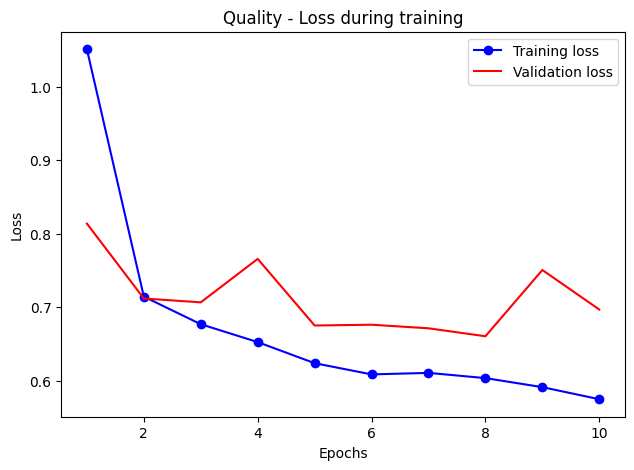

In [ ]:
# Plot Quality Loss
import matplotlib.pyplot as plt

history_dict = history.history
qLoss = history_dict['dense_6_loss']
val_qLoss = history_dict['val_dense_6_loss']
epochs = range(1, len(qLoss) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, qLoss, 'bo-', label='Training loss')
plt.plot(epochs, val_qLoss, 'r-', label='Validation loss')
plt.title('Quality - Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

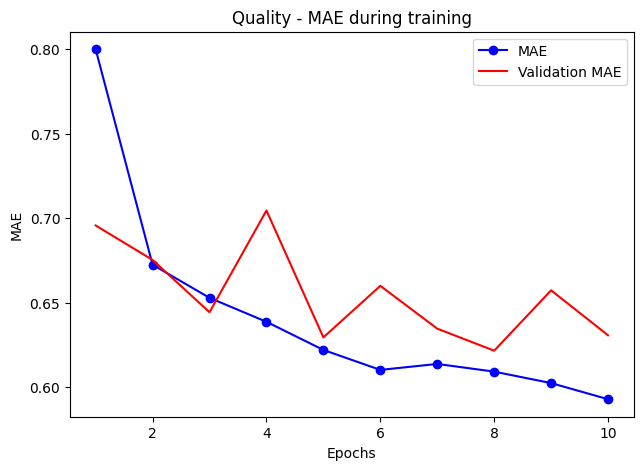

In [ ]:
# Plot Quality MAE
qmae = history_dict['dense_6_mae']
val_qmae = history_dict['val_dense_6_mae']

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, qmae, 'bo-', label='MAE')
plt.plot(epochs, val_qmae, 'r-', label='Validation MAE')
plt.title('Quality - MAE during training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

#### Difficulty Results

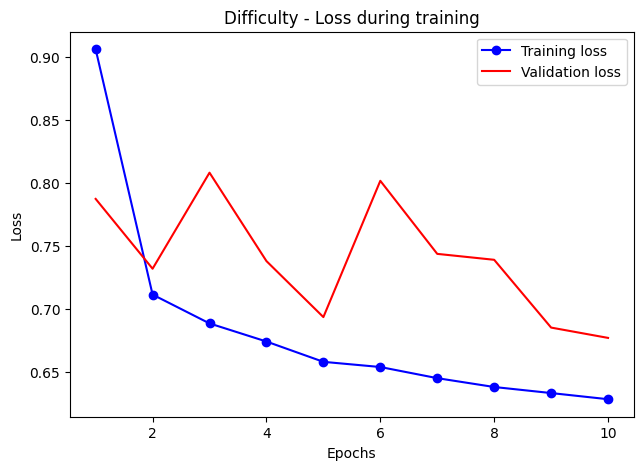

In [ ]:
# Plot Difficulty Loss
import matplotlib.pyplot as plt

history_dict = history.history
dLoss = history_dict['dense_7_loss']
val_dLoss = history_dict['val_dense_7_loss']
epochs = range(1, len(dLoss) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, dLoss, 'bo-', label='Training loss')
plt.plot(epochs, val_dLoss, 'r-', label='Validation loss')
plt.title('Difficulty - Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

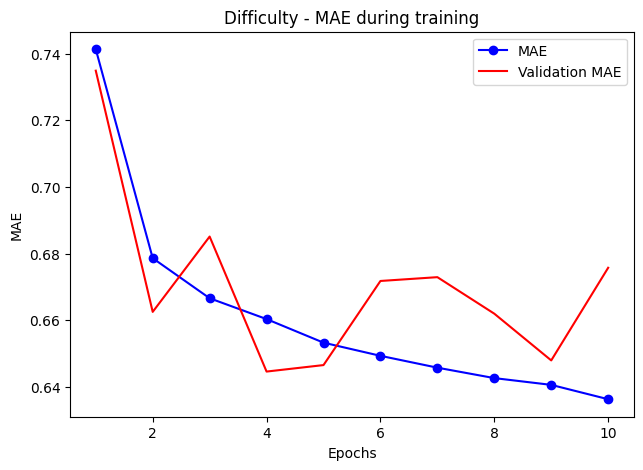

In [ ]:
# Plot Difficulty MAE
dmae = history_dict['dense_7_mae']
val_dmae = history_dict['val_dense_7_mae']

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, dmae, 'bo-', label='MAE')
plt.plot(epochs, val_dmae, 'r-', label='Validation MAE')
plt.title('Difficulty - MAE during training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

# Large Dataset (only)

This section of code is intended to document some of the different approaches our group took to improving our code over time.

## Embedding

Import collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers import LayerNormalization, Dropout, Input
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
import tensorflow as tf

grab RateMyProfessor_Sample data.csv data from location in MyDrive

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/RateMyProfessor_Sample data.csv'
df = pd.read_csv(dataset_path)

### Preprocessing

preprocess data and extract text and labels

In [ ]:
df = df.dropna(subset=['comments', 'student_star', 'student_difficult'])
comments = df['comments'].values
quality_labels = df['student_star'].values
difficulty_labels = df['student_difficult'].values

In [ ]:
!pip install contractions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 13.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import contractions
import re

# Assuming you've already imported your data and created the DataFrame 'df'

# Drop rows with NaN values in specified columns
df = df.dropna(subset=['comments', 'student_star', 'student_difficult'])

# Create a new column to store the comments before applying contractions
df['comments_before'] = df['comments']

# Expand contractions in the 'comments' column
df['comments'] = df['comments'].apply(contractions.fix)

# Lowercasing
df['comments'] = df['comments'].str.lower()

# Removing Punctuation and Special Characters
df['comments'] = df['comments'].apply(lambda x: re.sub(r'[^\w\s-]', '', x))
df['comments'] = df['comments'].apply(lambda x: x.replace('/', ' '))

df['comments'] = df['comments'].apply(lambda x: re.sub(r'(\w+)\s?/\s?(\w+)', r'\1 \2', x))




# Extract columns
comments_before = df['comments_before'].values
comments_after = df['comments'].values

# Print some comments before and after
for i in range(10):
    print("Before:", comments_before[i])
    print("After:", comments_after[i])
    print("-------------------------")


Before: This class is hard, but its a two-in-one gen-ed knockout, and the content is very stimulating. Unlike most classes, you have to actually participate to pass. Sections are easy and offer extra credit every week. Very funny dude. Not much more I can say.
After: this class is hard but its a two-in-one gen-ed knockout and the content is very stimulating unlike most classes you have to actually participate to pass sections are easy and offer extra credit every week very funny dude not much more i can say
-------------------------
Before: Definitely going to choose Prof. Looney\'s class again! Interesting class and easy A. You can bring notes to exams so you don\'t need to remember a lot. Lots of bonus points available and the observatory sessions are awesome!
After: definitely going to choose prof looneys class again interesting class and easy a you can bring notes to exams so you dont need to remember a lot lots of bonus points available and the observatory sessions are awesome
---

In [ ]:

comments = df['comments'].values
quality_labels = df['student_star'].values
difficulty_labels = df['student_difficult'].values

In [ ]:
import numpy as np

# Count NaN values in quality labels
quality_empty_count = np.isnan(quality_labels).sum()

# Count NaN values in difficulty labels
difficulty_empty_count = np.isnan(difficulty_labels).sum()

print("Number of empty quality labels:", quality_empty_count)
print("Number of empty difficulty labels:", difficulty_empty_count)


Number of empty quality labels: 0
Number of empty difficulty labels: 0


In [ ]:
import numpy as np

# Get unique quality labels
unique_quality_labels = np.unique(quality_labels[~np.isnan(quality_labels)])

# Get unique difficulty labels
unique_difficulty_labels = np.unique(difficulty_labels[~np.isnan(difficulty_labels)])

# Count number of unique quality labels
num_unique_quality_labels = len(unique_quality_labels)

# Count number of unique difficulty labels
num_unique_difficulty_labels = len(unique_difficulty_labels)

print("Number of unique quality labels:", num_unique_quality_labels)
print("Unique quality labels:", unique_quality_labels)

print("Number of unique difficulty labels:", num_unique_difficulty_labels)
print("Unique difficulty labels:", unique_difficulty_labels)


Number of unique quality labels: 9
Unique quality labels: [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Number of unique difficulty labels: 5
Unique difficulty labels: [1. 2. 3. 4. 5.]


In [ ]:
# Define classification thresholds for quality labels
quality_thresholds = [0, 2.5, 3.5, 5]

# Define classification thresholds for difficulty labels
difficulty_thresholds = [0, 2, 3, 5]

# Convert labels to classes
quality_classes = np.digitize(quality_labels, bins=quality_thresholds) - 1
difficulty_classes = np.digitize(difficulty_labels, bins=difficulty_thresholds) - 1


In [ ]:
# Get unique quality labels
unique_quality_labels = np.unique(quality_classes[~np.isnan(quality_classes)])

# Get unique difficulty labels
unique_difficulty_labels = np.unique(difficulty_classes[~np.isnan(difficulty_classes)])

print(unique_quality_labels)
print(unique_difficulty_labels)
print(quality_labels)

[0 1 2 3]
[0 1 2 3]
[5. 5. 4. ... 5. 4. 5.]


Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
maxlen = 100  # Assuming a maximum sequence length of 100
data = pad_sequences(sequences, maxlen=maxlen)

Split the dataset with a test size of 20%

In [ ]:
x_train, x_test, y_train_quality, y_test_quality, y_train_difficulty, y_test_difficulty = train_test_split(
    data, quality_classes, difficulty_classes, test_size=0.2, random_state=42)

Create embedding matrix

In [ ]:
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt', encoding='utf-8') as f:
    next(f)  # Skip the header line
    for line in f:
        values = line.split()
        word = values[0]
        if len(values) > 1:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
print(x_train.shape)
print(y_train_quality.shape)
print(x_test.shape)
print(y_test_quality.shape)

(15994, 100)
(15994,)
(3999, 100)
(3999,)


## RNN

### Regression

Define the RNN model architecture for quality prediction, includes compiling, training and evaulation based of 10 epochs with a batch size of 32.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a callback to save the best model during training
checkpoint_path = "quality_model_regress_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_mae', patience=5, verbose=1, mode='min', restore_best_weights=True)

quality_model = Sequential()
quality_model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
quality_model.add(Bidirectional(LSTM(64)))
quality_model.add(Dense(1, activation='linear'))

# Compile the quality model
quality_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the quality model
quality_model.fit(x_train, y_train_quality, epochs=50, batch_size=32, validation_data=(x_test, y_test_quality), callbacks=[checkpoint, early_stopping])

# Evaluate the quality model
quality_loss, quality_mae = quality_model.evaluate(x_test, y_test_quality)
print("quality prediction:", quality_mae)


Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.9915 - mae: 0.8222
Epoch 1: val_mae improved from inf to 0.67322, saving model to quality_model_checkpoint.h5
500/500 [==============================] - 127s 246ms/step - loss: 0.9915 - mae: 0.8222 - val_loss: 0.7059 - val_mae: 0.6732
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.6708 - mae: 0.6558
Epoch 2: val_mae improved from 0.67322 to 0.64602, saving model to quality_model_checkpoint.h5
500/500 [==============================] - 122s 245ms/step - loss: 0.6708 - mae: 0.6558 - val_loss: 0.6455 - val_mae: 0.6460
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.6055 - mae: 0.6164
Epoch 3: val_mae improved from 0.64602 to 0.63817, saving model to quality_model_checkpoint.h5
500/500 [==============================] - 115s 230ms/step - loss: 0.6055 - mae: 0.6164 - val_loss: 0.6490 - val_mae: 0.6382
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 0

quality prediction: 0.6002991199493408

Run the same as above but now for difficulty predictions

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a callback to save the best model during training
checkpoint_path = "difficulty_model_regress_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_mae', patience=5, verbose=1, mode='min', restore_best_weights=True)

difficulty_model = Sequential()
difficulty_model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                               input_length=maxlen, trainable=False))
difficulty_model.add(Bidirectional(LSTM(64)))
difficulty_model.add(Dense(1, activation='linear'))

# Compile the difficulty model
difficulty_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the difficulty model
difficulty_model.fit(x_train, y_train_difficulty, epochs=50, batch_size=32, validation_data=(x_test, y_test_difficulty), callbacks=[checkpoint, early_stopping])

# Evaluate the difficulty model
difficulty_loss, difficulty_mae = difficulty_model.evaluate(x_test, y_test_difficulty)
print("difficulty prediction:", difficulty_mae)


Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.8702 - mae: 0.7651
Epoch 1: val_mae improved from inf to 0.74305, saving model to quality_model_checkpoint.h5
500/500 [==============================] - 124s 240ms/step - loss: 0.8702 - mae: 0.7651 - val_loss: 0.7753 - val_mae: 0.7430
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.7145 - mae: 0.6880
Epoch 2: val_mae improved from 0.74305 to 0.68687, saving model to quality_model_checkpoint.h5
500/500 [==============================] - 120s 241ms/step - loss: 0.7145 - mae: 0.6880 - val_loss: 0.6997 - val_mae: 0.6869
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.6755 - mae: 0.6653
Epoch 3: val_mae improved from 0.68687 to 0.67700, saving model to quality_model_checkpoint.h5
500/500 [==============================] - 114s 229ms/step - loss: 0.6755 - mae: 0.6653 - val_loss: 0.6889 - val_mae: 0.6770
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 0

### Classification

RNN TEXT Classification Model

In [ ]:
from keras.utils import to_categorical

# Convert labels to one-hot encoding
quality_labels_onehot = to_categorical(quality_classes, num_classes=4)
difficulty_labels_onehot = to_categorical(difficulty_classes, num_classes=4)

In [ ]:
x_train, x_test, y_train_quality, y_test_quality, y_train_difficulty, y_test_difficulty = train_test_split(
    data, quality_labels_onehot, difficulty_labels_onehot, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['comments'].values)
sequences = tokenizer.texts_to_sequences(df['comments'].values)
maxlen = 100  # Assuming a maximum sequence length of 100
data = pad_sequences(sequences, maxlen=maxlen)

In [ ]:
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt', encoding='utf-8') as f:
    next(f)  # Skip the header line
    for line in f:
        values = line.split()
        word = values[0]
        if len(values) > 1:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
print(x_train.shape)
print(y_train_quality.shape)
print(x_test.shape)
print(y_test_quality.shape)

(15994, 100)
(15994, 4)
(3999, 100)
(3999, 4)


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a callback to save the best model during training
checkpoint_path = "quality_model_class_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Build the quality model
quality_model = Sequential()
quality_model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
quality_model.add(Bidirectional(LSTM(64)))
quality_model.add(Dense(4, activation='softmax'))  # Output 4 classes for sentiment classification

# Compile the quality model
quality_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the quality model with checkpoint and early stopping callbacks
quality_model.fit(x_train, y_train_quality, epochs=50, batch_size=32, validation_data=(x_test, y_test_quality), callbacks=[checkpoint, early_stopping])

# Evaluate the quality model
quality_loss, quality_accuracy = quality_model.evaluate(x_test, y_test_quality)
print("quality prediction:", quality_accuracy)


Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 1.0915 - accuracy: 0.5011
Epoch 1: val_accuracy improved from -inf to 0.54789, saving model to quality_model_checkpoint.h5
500/500 [==============================] - 127s 243ms/step - loss: 1.0915 - accuracy: 0.5011 - val_loss: 0.9904 - val_accuracy: 0.5479
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.5739
Epoch 2: val_accuracy improved from 0.54789 to 0.56989, saving model to quality_model_checkpoint.h5
500/500 [==============================] - 114s 228ms/step - loss: 0.9607 - accuracy: 0.5739 - val_loss: 0.9487 - val_accuracy: 0.5699
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 0.9144 - accuracy: 0.5908
Epoch 3: val_accuracy did not improve from 0.56989
500/500 [==============================] - 109s 218ms/step - loss: 0.9144 - accuracy: 0.5908 - val_loss: 0.9428 - val_accuracy: 0.5636
Epoch 4/50
500/500 [==============================] - ETA: 

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define a callback to save the best model during training
checkpoint_path = "difficulty_model_class_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Build the quality model
difficulty_model = Sequential()
difficulty_model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
difficulty_model.add(Bidirectional(LSTM(64)))
difficulty_model.add(Dense(4, activation='softmax'))  # Output 4 classes for sentiment classification

# Compile the quality model
difficulty_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the quality model with checkpoint and early stopping callbacks
difficulty_model.fit(x_train, y_train_difficulty, epochs=50, batch_size=32, validation_data=(x_test, y_test_difficulty), callbacks=[checkpoint, early_stopping])

# Evaluate the quality model
difficulty_loss, difficulty_accuracy = difficulty_model.evaluate(x_test, y_test_difficulty)
print("difficulty prediction:", difficulty_accuracy)


Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 1.2088 - accuracy: 0.4849
Epoch 1: val_accuracy improved from -inf to 0.51438, saving model to difficulty_model_class_checkpoint.h5
500/500 [==============================] - 116s 225ms/step - loss: 1.2088 - accuracy: 0.4849 - val_loss: 1.1429 - val_accuracy: 0.5144
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 1.1152 - accuracy: 0.5197
Epoch 2: val_accuracy improved from 0.51438 to 0.51988, saving model to difficulty_model_class_checkpoint.h5
500/500 [==============================] - 112s 224ms/step - loss: 1.1152 - accuracy: 0.5197 - val_loss: 1.1119 - val_accuracy: 0.5199
Epoch 3/50
500/500 [==============================] - ETA: 0s - loss: 1.0787 - accuracy: 0.5355
Epoch 3: val_accuracy did not improve from 0.51988
500/500 [==============================] - 108s 217ms/step - loss: 1.0787 - accuracy: 0.5355 - val_loss: 1.1077 - val_accuracy: 0.5186
Epoch 4/50
500/500 [=====================

## Transformer

Import libraries

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence

Create Transformer Block

In [ ]:
# Helper functions
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_block(x, num_heads, d_model, rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn_output = Dense(d_model, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

In [ ]:
x_train, x_test, y_train_quality, y_test_quality, y_train_difficulty, y_test_difficulty = train_test_split(
    data, quality_classes, difficulty_classes, test_size=0.2, random_state=42)

ALready have loaded dataset, tokenized, and split dataset from before.
Load GloVe embedding

In [ ]:
# Load GloVe embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt', encoding='utf-8') as f:
    next(f)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Transformer Model Architecture

In [ ]:
# Transformer Model Architecture
input_layer = Input(shape=(maxlen,))
x = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)
x *= tf.math.sqrt(tf.cast(embedding_dim, tf.float32))
x += positional_encoding(maxlen, embedding_dim)
x = transformer_block(x, num_heads=8, d_model=embedding_dim)

# Output layers for quality and difficulty
x = GlobalAveragePooling1D()(x)
output_quality = Dense(1, activation='linear')(x)
output_difficulty = Dense(1, activation='linear')(x)

# Model Compilation
model = Model(inputs=input_layer, outputs=[output_quality, output_difficulty])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Model Training
model.fit(x_train, [y_train_quality, y_train_difficulty], epochs=10, batch_size=32, validation_data=(x_test, [y_test_quality, y_test_difficulty]))

# Evaluate the model
overall_loss, quality_loss, difficulty_loss, quality_mae, difficulty_mae = model.evaluate(x_test, [y_test_quality, y_test_difficulty])
print("Quality MAE:", quality_mae)
print("Difficulty MAE:", difficulty_mae)

Epoch 1/10
500/500 [==============================] - 863s 2s/step - loss: 2.0649 - dense_2_loss: 1.1055 - dense_3_loss: 0.9594 - dense_2_mae: 0.8218 - dense_3_mae: 0.7648 - val_loss: 1.5177 - val_dense_2_loss: 0.6976 - val_dense_3_loss: 0.8201 - val_dense_2_mae: 0.6733 - val_dense_3_mae: 0.6969
Epoch 2/10
500/500 [==============================] - 860s 2s/step - loss: 1.4863 - dense_2_loss: 0.7307 - dense_3_loss: 0.7556 - dense_2_mae: 0.6816 - dense_3_mae: 0.7059 - val_loss: 1.4251 - val_dense_2_loss: 0.6659 - val_dense_3_loss: 0.7591 - val_dense_2_mae: 0.6303 - val_dense_3_mae: 0.7175
Epoch 3/10
500/500 [==============================] - 855s 2s/step - loss: 1.4032 - dense_2_loss: 0.6767 - dense_3_loss: 0.7265 - dense_2_mae: 0.6508 - dense_3_mae: 0.6914 - val_loss: 1.4027 - val_dense_2_loss: 0.6901 - val_dense_3_loss: 0.7126 - val_dense_2_mae: 0.6675 - val_dense_3_mae: 0.6846
Epoch 4/10
500/500 [==============================] - 847s 2s/step - loss: 1.3419 - dense_2_loss: 0.6461 - de

Best Transformer, please use

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence

# Constants
EMBEDDING_DIM = 300
HIDDEN_DIM = 200
OUTPUT_DIM = 1
BATCH_SIZE = 32
NUM_EPOCHS = 10
nhead = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load GloVe embeddings from a file
def load_glove_embeddings(path):
    with open(path, 'r', encoding='utf-8') as file:
        vocab = {}
        embeddings = []
        for idx, line in enumerate(file):
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(v) for v in values[1:]], dtype=torch.float)
            vocab[word] = idx
            embeddings.append(vector)
        embeddings = torch.stack(embeddings)
    return vocab, embeddings

# Load the dataset
class CommentsDataset(Dataset):
    def __init__(self, filepath, glove_path):
        self.data = pd.read_csv(filepath)
        self.tokenizer = get_tokenizer('basic_english')
        self.vocab, self.glove_embeddings = load_glove_embeddings(glove_path)
        self.comments = [
            torch.tensor(
                [self.vocab[token] for token in self.tokenizer(str(x).lower().strip()) if token in self.vocab],
                dtype=torch.long
            ) for x in self.data['comments'].fillna('')
        ]
        self.targets = torch.tensor(self.data['diff_index'].values, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        target = self.targets[idx]
        return comment, target

# Transformer Model
class CommentTransformer(nn.Module):
    def __init__(self, embeddings):
        super(CommentTransformer, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        encoder_layer = nn.TransformerEncoderLayer(d_model=EMBEDDING_DIM, nhead=nhead, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.fc = nn.Linear(EMBEDDING_DIM, OUTPUT_DIM)

    def forward(self, text):
        embedded = self.embedding(text)
        transformer_out = self.transformer_encoder(embedded)
        output = self.fc(transformer_out.mean(dim=1))
        return output

# Collate function for DataLoader
def collate_batch(batch):
    comments_list, targets_list = [], []
    for (comment, target) in batch:
        comments_list.append(comment)
        targets_list.append(target)
    comments_padded = pad_sequence(comments_list, batch_first=True, padding_value=0)  # Padding
    targets = torch.stack(targets_list)
    return comments_padded, targets

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (comments, targets) in enumerate(train_loader):
            comments, targets = comments.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            predictions = model(comments)
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_epoch_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Average Loss: {average_epoch_loss}')

# Main script
filepath = '/content/drive/MyDrive/Colab Notebooks/RateMyProfessor_Sample data.csv'
glove_path = '/content/drive/MyDrive/Colab Notebooks/glove/glove.6B.300d.txt'

dataset = CommentsDataset(filepath, glove_path)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

model = CommentTransformer(dataset.glove_embeddings).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS)

# Save the model
torch.save(model.state_dict(), 'comment_transformer_model.pth')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Average Loss: 0.6810710085868835
Epoch 2, Average Loss: 0.6192629982948303
Epoch 3, Average Loss: 0.6156022855758667
Epoch 4, Average Loss: 0.6157629336833954
Epoch 5, Average Loss: 0.6156298233509063
Epoch 6, Average Loss: 0.6110174930095673
Epoch 7, Average Loss: 0.6094311248779297
Epoch 8, Average Loss: 0.6104958695411682
Epoch 9, Average Loss: 0.6099773699283599
Epoch 10, Average Loss: 0.6121758715629577


# Discussion of our approach

So far we utilised same approaches on a combined dataset as well as on large dataset. We saw that model performs better with combined dataset.
Tests comparing the combined datasets (large and small) vs using either dataset alone greatly favored the use of the combined datasets, which is understandable since more data tends to lead to better resuts.

**RNN:**

The differences in MAE and accuracy for regression and classification approaches, when compared between the combined vs large-only datasets, were small but noticeable and favored the combined dataset as expected. This supports our belief that better performance could be achieved with even more data.

**Transformer:**

Keras: We will start by comparing the results of our Keras-based transformer to the regression-RNN.

MAE Comparison:

Transformer Quality: 0.6306160092353821

Transformer Difficulty: 0.6757775545120239


RNN:

RNN Quality: 0.5824604034423828

RNN Difficulty: 0.6287729740142822

Our results comparing the Transformer to the RNN show that they have similar performance, slightly favoring the RNN. This may be due to the relatively small number of data values for training the Transformer, or due to limits in our ability to train and improve the model. It became difficult to optimize the transformer due to it eating through Google Collab computation resources forcing us to use CPU/TPU runtimes and getting multi-hour training times, but our efforts to improve it still yielded positive results.

Overall this has served as a good introduction to the group for transformers.


Pytorch: We experimented with pytorch implementations of transformers as well which we have included here. The best raw loss numbers we have been able to produce with a transformer as a group were created by a pytorch-based transformer. That said, it is much more difficult to directly compare this transformer to our keras-based RNN's. We have included it as potentially the best performing version of a transformer our group has come up with, but performed our analysis on the keras-based model for ease of direct comparison.